In [206]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.svm import SVC

In [207]:
# Load the data
df = pd.read_csv("./hr_comma_sep.csv")

In [208]:
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [209]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
satisfaction_level       14999 non-null float64
last_evaluation          14999 non-null float64
number_project           14999 non-null int64
average_montly_hours     14999 non-null int64
time_spend_company       14999 non-null int64
Work_accident            14999 non-null int64
left                     14999 non-null int64
promotion_last_5years    14999 non-null int64
sales                    14999 non-null object
salary                   14999 non-null object
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [210]:
df.isnull().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
sales                    0
salary                   0
dtype: int64

In [211]:
df['sales'].value_counts()

sales          4140
technical      2720
support        2229
IT             1227
product_mng     902
marketing       858
RandD           787
accounting      767
hr              739
management      630
Name: sales, dtype: int64

In [212]:
df['salary'].value_counts()

low       7316
medium    6446
high      1237
Name: salary, dtype: int64

#### Rename Sales column to Department
#### Convert Salary column to ordinal
#### create dummy feature from Department

In [213]:

# Rename Sales feature to department
df = df.rename(columns={"sales": "department"})

# Salary to ordinal
salary_map = {"low": 0, "medium": 1, "high": 2}
df["salary"] = df["salary"].map(salary_map)

# Create dummy variables for department feature
df = pd.get_dummies(df, columns=["department"], drop_first=True)
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,salary,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,1,0,0,0,0,0,0,0,0,1,0,0
1,0.80,0.86,5,262,6,0,1,0,1,0,0,0,0,0,0,1,0,0
2,0.11,0.88,7,272,4,0,1,0,1,0,0,0,0,0,0,1,0,0
3,0.72,0.87,5,223,5,0,1,0,0,0,0,0,0,0,0,1,0,0
4,0.37,0.52,2,159,3,0,1,0,0,0,0,0,0,0,0,1,0,0


In [214]:
df.shape

(14999, 18)

0    11428
1     3571
Name: left, dtype: int64


([<matplotlib.axis.XTick at 0x1a20881ba8>,
 <a list of 2 Text xticklabel objects>)

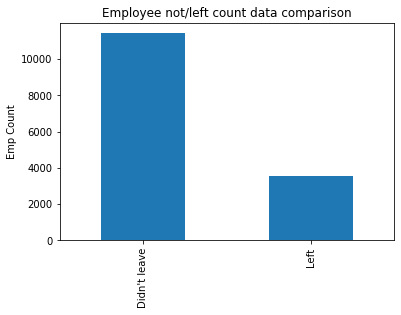

In [215]:
print(df["left"].value_counts())
df["left"].value_counts().plot(kind='bar')
plt.ylabel('Emp Count')
plt.title('Employee not/left count data comparison')
plt.xticks((0, 1), ["Didn't leave", "Left"])

Imbalance dataset found  
--> metric F1-score or AUC(area under ROC curve) 
There are three ways to deal with this issue:
we also try Upsampling the minority class and downsampling the majority class.
Also generate synthetic training examples

In [216]:
# train and test sets: 80/20
X = df.loc[:, df.columns != "left"].values
y = df.loc[:, df.columns == "left"].values.ravel()
X= StandardScaler().fit(X).transform(X)
print(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)
# Upsample minor class
X_train_u, y_train_u = resample(X_train[y_train == 1],
                                y_train[y_train == 1],
                                replace=True,
                                n_samples=X_train[y_train == 0].shape[0],
                                random_state=1)
X_train_u = np.concatenate((X_train[y_train == 0], X_train_u))
y_train_u = np.concatenate((y_train[y_train == 0], y_train_u))
print(y_train_u.shape)

# Downsample major class
X_train_d, y_train_d = resample(X_train[y_train == 0],
                                y_train[y_train == 0],
                                replace=True,
                                n_samples=X_train[y_train == 1].shape[0],
                                random_state=1)
X_train_d = np.concatenate((X_train[y_train == 1], X_train_d))
y_train_d = np.concatenate((y_train[y_train == 1], y_train_d))

print("Original shape:", X_train.shape)
print("Upsampled shape:", X_train_u.shape)
print("Downsampled shape:", X_train_d.shape)

[1 1 1 ... 1 1 1]
(18284,)
Original shape: (11999, 17)
Upsampled shape: (18284, 17)
Downsampled shape: (5714, 17)


PCA is not required as much as it has 17 feature with better interpretation 
PCA to check maximum the variation in the data.

[0.1078147  0.07975255 0.07766479 0.07081241 0.06759775 0.06443285
 0.0628709  0.06239438 0.06201072 0.06156182 0.05722036 0.05238222
 0.05020699 0.04843102 0.03701255 0.03213212 0.00570187]
[0.1078147  0.18756726 0.26523205 0.33604446 0.4036422  0.46807506
 0.53094596 0.59334034 0.65535106 0.71691288 0.77413324 0.82651546
 0.87672244 0.92515346 0.96216602 0.99429813 1.        ]


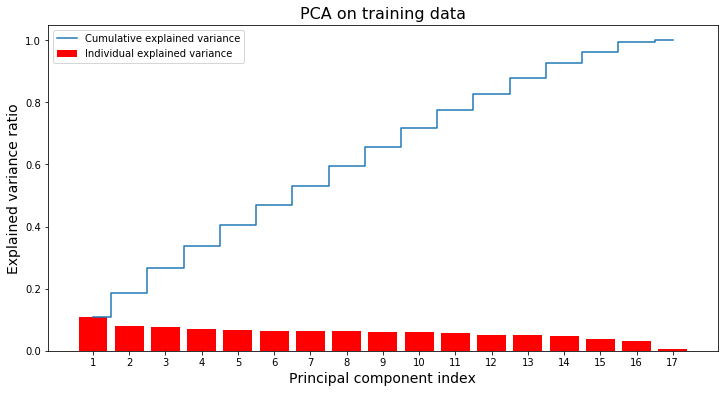

In [217]:

# Build PCA using standarized trained data
pca = PCA(n_components=None, svd_solver="full")
pca.fit(StandardScaler().fit_transform(X_train))
print(pca.explained_variance_ratio_)
cum_var_exp = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(12, 6))
plt.bar(range(1, 18), pca.explained_variance_ratio_, align="center",
        color='red', label="Individual explained variance")
plt.step(range(1, 18), cum_var_exp, where="mid", label="Cumulative explained variance")
plt.xticks(range(1, 18))
plt.legend(loc="best")
plt.xlabel("Principal component index", {"fontsize": 14})
plt.ylabel("Explained variance ratio", {"fontsize": 14})
plt.title("PCA on training data", {"fontsize": 16});
print(cum_var_exp)

it almost similar variation and takes around 14,15,16 component for maximum vairation so No need 
of PCA as all features are in descent 

In [218]:
# Build random forest classifier
method_data = {"Original": (X_train, y_train),
                "Upsampled": (X_train_u, y_train_u),
                "Downsampled": (X_train_d, y_train_d)}

def tuningParam(method_data):
    for data_i in method_data.keys():
        rd_clf= RandomForestClassifier()
        hyperparam_grid={
        "n_estimators": [10, 50, 100],
        "max_features": ["sqrt", "log2", 0.4, 0.5],
        "min_samples_leaf": [1, 3, 5],
        "criterion": ["gini", "entropy"]}
        gs_rf = GridSearchCV(rd_clf,hyperparam_grid,scoring="f1",cv=5)
        print(method_data[data_i][0].shape)
        gs_rf.fit(method_data[data_i][0],method_data[data_i][1])
        print(gs_rf.best_params_)
        print(gs_rf.best_score_)
        
tuningParam(method_data)
        
        
    
    



(11999, 17)
{'criterion': 'gini', 'max_features': 0.4, 'min_samples_leaf': 1, 'n_estimators': 100}
0.9804623134035417
(18284, 17)
{'criterion': 'gini', 'max_features': 0.4, 'min_samples_leaf': 1, 'n_estimators': 100}
0.997976212633725
(5714, 17)
{'criterion': 'entropy', 'max_features': 0.5, 'min_samples_leaf': 1, 'n_estimators': 50}
0.9813887597005412


area under curve 0.99


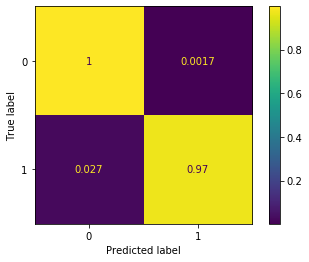

In [219]:
#X_train, y_train = np.copy(X_train_u), np.copy(y_train_u)

# Delete original and downsampled data
#del X_train_u, y_train_u, X_train_d, y_train_d

# Refit RF classifier using best params
clf_rf = make_pipeline(StandardScaler(),RandomForestClassifier(n_estimators=100,
                                              criterion="entropy",
                                              max_features=0.4,
                                              min_samples_leaf=1))


clf_rf.fit(X_train, y_train)

# Plot confusion matrix and ROC curve
metrics.plot_confusion_matrix(clf_rf, X_test, y_test,normalize='true')
print("area under curve {:.2f}".format(metrics.roc_auc_score(y_test, clf_rf.predict(X_test))))


In [220]:

gb_clf= Pipeline([('clf',GradientBoostingClassifier())])
hyperparam_grid={"clf__max_features": ["log2", 0.5],
                 "clf__n_estimators": [10, 50, 100],
                 "clf__learning_rate": [0.001, 0.01, 0.1],
                 "clf__max_depth": [1, 2, 3]}
gs_gb = GridSearchCV(gb_clf,hyperparam_grid,scoring="f1",cv=5)
gs_gb.fit(X_train,y_train)
print(gs_gb.best_params_)
print(gs_gb.best_score_)
        

{'clf__learning_rate': 0.1, 'clf__max_depth': 3, 'clf__max_features': 0.5, 'clf__n_estimators': 100}
0.9485772139564546


area under cover 0.96


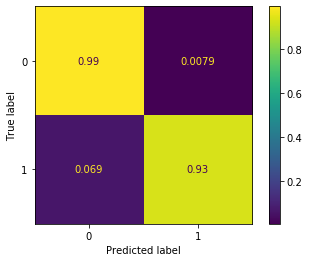

In [221]:
clf_gb = make_pipeline(StandardScaler(),GradientBoostingClassifier(n_estimators=100,
                                              learning_rate=0.1,
                                              max_features=0.5,
                                              max_depth=3))


clf_gb.fit(X_train, y_train)

# Plot confusion matrix and ROC curve
metrics.plot_confusion_matrix(clf_gb, X_test, y_test,normalize='true')
print("area under cover {:.2f}".format(metrics.roc_auc_score(y_test, clf_gb.predict(X_test))))

In [222]:
knn_clf= KNeighborsClassifier()
hyperparam_grid={"n_neighbors": range(1,15),
                 "weights": ['uniform','distance']}
gs_knn = GridSearchCV(knn_clf,hyperparam_grid,scoring="f1",cv=2)
gs_knn.fit(X_train,y_train)
print(gs_knn.best_params_)
print(gs_knn.best_score_)

{'n_neighbors': 4, 'weights': 'distance'}
0.902622811672059


area under cover 0.97


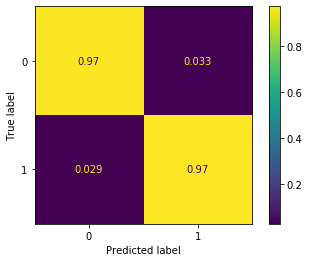

In [223]:
clf_knn = make_pipeline(StandardScaler(),KNeighborsClassifier(n_neighbors=4,
                                              weights='distance'))


clf_knn.fit(X_train, y_train)

# Plot confusion matrix and ROC curve
metrics.plot_confusion_matrix(clf_knn, X_test, y_test,normalize='true')
print("area under cover {:.2f}".format(metrics.roc_auc_score(y_test, clf_knn.predict(X_test))))

In [224]:
lg_clf= LogisticRegression(solver='lbfgs')
hyperparam_grid = {"penalty": [ "l2"],
                   "C":  np.arange(0.5,20,0.5),
                   "fit_intercept": [True, False]
                  }
gs_lg = GridSearchCV(lg_clf,hyperparam_grid,scoring="f1",cv=2)
gs_lg.fit(X_train,y_train)
print(gs_lg.best_params_)
print(gs_lg.best_score_)

{'C': 0.5, 'fit_intercept': False, 'penalty': 'l2'}
0.5586010228435049


area under cover 0.74


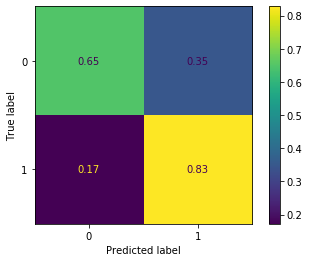

In [225]:
clf_lg = make_pipeline(StandardScaler(),LogisticRegression(solver='lbfgs',C=0.5, fit_intercept= False, penalty='l2'))


clf_lg.fit(X_train, y_train)

# Plot confusion matrix and ROC curve
metrics.plot_confusion_matrix(clf_lg, X_test, y_test,normalize='true')
print("area under cover {:.2f}".format(metrics.roc_auc_score(y_test, clf_lg.predict(X_test))))

In [226]:
svc_clf= SVC(kernel='rbf')
Cs = [0.001, 0.01, 0.1, 1, 10]
gammas = [0.001, 0.01, 0.1, 1]
hyperparam_grid = {'C':Cs,'gamma':gammas}
gs_svc = GridSearchCV(svc_clf,hyperparam_grid,scoring="f1",cv=2)
gs_svc.fit(X_train,y_train)
print(gs_svc.best_params_)
print(gs_svc.best_score_)

{'C': 10, 'gamma': 1}
0.9295276701422419


area under cover 0.97


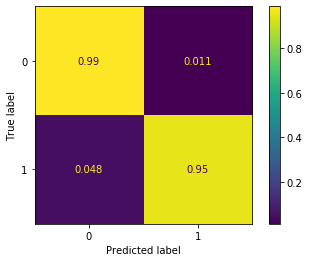

In [227]:
clf_svc = make_pipeline(StandardScaler(),SVC(kernel='rbf',C=10,gamma=1))


clf_svc.fit(X_train, y_train)

# Plot confusion matrix and ROC curve
metrics.plot_confusion_matrix(clf_svc, X_test, y_test,normalize='true')
print("area under cover {:.2f}".format(metrics.roc_auc_score(y_test, clf_svc.predict(X_test))))

In [228]:
estimators = {"RF": clf_rf,
              "LR": clf_lg,
              "SVC": clf_svc,
              "GB": clf_gb,
              "KNN": clf_knn}
for estimator in estimators.keys():
    print("{}: {:.2f}%, {:.2f}%.".format(estimator,
        metrics.accuracy_score(y_test, estimators[estimator].predict(X_test)) * 100,
         metrics.f1_score(y_test, estimators[estimator].predict(X_test)) * 100))

RF: 99.23%, 98.37%.
LR: 69.30%, 56.21%.
SVC: 98.00%, 95.77%.
GB: 97.77%, 95.20%.
KNN: 96.77%, 93.46%.


[13 12  6  8  9 11 10 15 16 14  5  7  1  2  3  4  0]
[ 0  4  3  2  1  7  5 14 16 15 10 11  9  8  6 12 13]


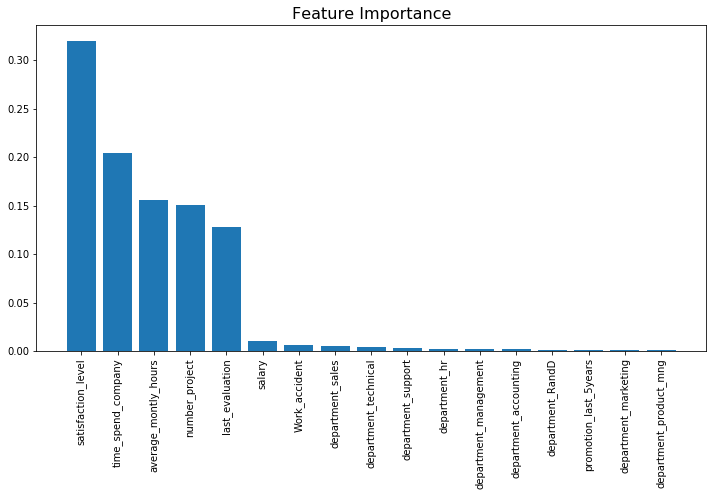

In [229]:
clf_rf = RandomForestClassifier(n_estimators=100,
                                              criterion="entropy",
                                              max_features=0.4,
                                              min_samples_leaf=1)


clf_rf.fit(StandardScaler().fit_transform(X_train), y_train)

# Plot features importance
importances = clf_rf.feature_importances_
print(np.argsort(clf_rf.feature_importances_))
indices = np.argsort(clf_rf.feature_importances_)[::-1]
print(indices)
plt.figure(figsize=(12, 6))
plt.bar(range(1, 18), importances[indices], align="center")
plt.xticks(range(1, 18), df.columns[df.columns != "left"][indices], rotation=90)
plt.title("Feature Importance", {"fontsize": 16});